In [55]:
import pandas as pd
import numpy as np
from itertools import combinations, permutations
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind
from statsmodels.stats import contingency_tables
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt

np.random.seed(42)

In [56]:
# udfs

# bootstrap function
def get_bootstrap_samples(data, n_samples):
    """Generates bootstrap samples using the data"""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

# median difference function
def get_stat_intervals(stat, alpha):
    """Returns confidence intervals for the statistic"""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# distirubtion comparison function
def compare_distributions(col, bins=50):
    """Plots 3 graphs for 2 groups: histogram, density plot, boxplot"""
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.hist(defa[col], bins=bins, alpha=0.5, label='default')
    plt.hist(nodefa[col], bins=bins, alpha=0.5, label='no default')
    plt.title('Histogram')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(defa[col], bins=bins, alpha=0.5, label='default', density=True)
    plt.hist(nodefa[col], bins=bins, alpha=0.5, label='no default', density=True)
    plt.title('Density plot')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.boxplot([defa[col], nodefa[col]])
    plt.xticks([1, 2], ['default', 'no default'])
    plt.title('Boxplot')
    plt.show()


# permutation test for 2 independent samples
def permutation_t_stat_2s(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}
    

# permutation test for independence
def permutation_stat_cat_ind(sample1, sample2):
    ct = pd.crosstab(sample1, sample2)
    return chi2_contingency(ct)[0]

def get_random_permutations(n, max_permutations):
    index = np.array(range(n))
    indices = set([tuple(index)])        
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return list(indices)

def permutation_null_dist_cat_ind(sample1, sample2, max_permutations = None):
    if not len(sample1) == len(sample2):
        raise ValueError("Samples should be paired and have the same size")
        
    n = len(sample1)
    
    if max_permutations:
        indices = get_random_permutations(n, max_permutations)
    else:
        indices = list(permutations(list(range(n))))
    
    distr = [permutation_stat_cat_ind(sample1, sample2[list(i)]) for i in indices]
    return distr

def permutation_test_cat_ind(sample1, sample2, max_permutations = None, return_distr = False):    
    t_stat = permutation_stat_cat_ind(sample1, sample2)
    
    null_distr = permutation_null_dist_cat_ind(sample1, sample2, max_permutations)
    
    p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
        
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}
    

The dataset for this assignment was collected in Taiwan in 2005, when the credit card issuers faced the cash and credit card debt crisis. 
In order to increase market share, card-issuing banks over-issued cash and credit cards to unqualified applicants. At the same time, most cardholders, irrespective of their repayment ability, overused credit card for consumption and accumulated heavy credit and cash–card debts. The crisis caused the blow to consumer finance confidence and was a big challenge for both banks and cardholders.

The data were collected from an important bank (a cash and credit card issuer) in Taiwan and the targets were credit card holders of the bank. Variables the dataset contains are:
- LIMIT_BAL: credit limit in NT dollars (including for client's family)
- GENDER: 1 = male, 2 = female
- EDUCATION: 0 = doctorate, 1 = masters; 2 = bachelor; 3 = school graduate; 4 = elementary education; 5= other; 6 = no data.
- MARITAL: marital status: 0 = no answer; 1 = married; 2 = single; 3 = no data.
- AGE: age in years
- PAY_APR – PAY_SEP : history of past monthly payments, from April (PAY_APR) to September (PAY_SEP) 2005. The measurement scale for the repayment status is 0 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- BILL_APR – BILL_SEP: the amount of bill statement (NT dollars) each month
- PAY_APR – PAY_SEP: the amount of previous payment (NT dollar)
- default: binary indicator of a default (1 = Yes, 0 = No)

We would like to explore whether there are differences between customers who defaulted and did not.

Assignment:
1. Credit limit: test whether there are differences between median credit limits of two groups.
2. Gender: test whether gender composition of two groups differ.
3. Education: test whether education levels differs between two groups. If it does, then how exactly?
4. Marital status: Check how marital status is related to the default indicator: you need to propose a measure by which you can measure the possible relationship of these variables and calculate its value.
5. Age: test whether there are differences between mean ages of clients in two groups.

# Credit limit

In [57]:
# read dataset, rename columns for convenience
credits = pd.read_csv('credit_card_default_analysis.csv', index_col='ID')
credits.columns = credits.columns.str.lower()

# split data into two groups: defaulted and not defaulted
defa = credits[credits.default == 1]
nodefa = credits[credits.default == 0]

# check sizes of groups
print(f"Defaulted df size: {defa.shape[0]}\nNot defaulted df size: {nodefa.shape[0]}")

Defaulted df size: 6636
Not defaulted df size: 23364


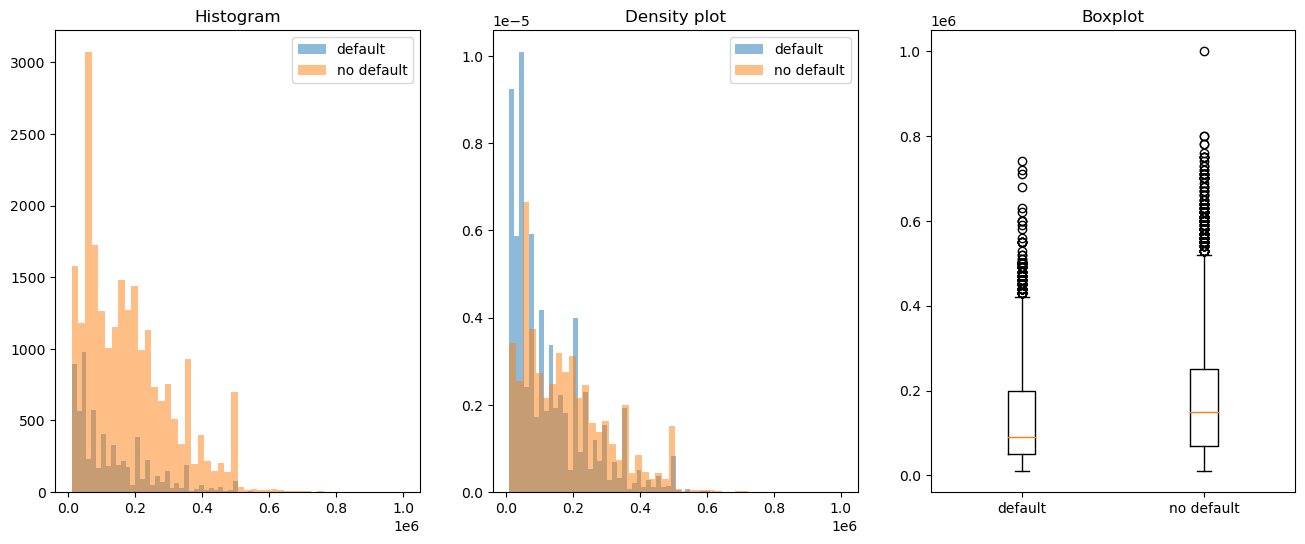

In [58]:
# checking distibutions of credit limit for both groups to decide which test to use
compare_distributions('limit_bal')

Let us examine the medians - both point and interval estimates - of the two groups. I use the bootstrap method to estimate the confidence intervals.

In [59]:
# point estimate
defa_median, nodefa_median = np.median(defa.limit_bal.values), np.median(nodefa.limit_bal.values)
print(f"Defaulted median (point estimate): {defa_median}\nNot defaulted median (point estimate): {nodefa_median}\n")

# bootstrap
defa_median_scores = list(map(np.median, get_bootstrap_samples(defa.limit_bal.values, 5000)))
nodefa_median_scores = list(map(np.median, get_bootstrap_samples(nodefa.limit_bal.values, 5000)))

# confidence interval
defa_median_confint, nodefa_median_confint = get_stat_intervals(defa_median_scores, 0.05), get_stat_intervals(nodefa_median_scores, 0.05)

# confidence interval
print(f"Defaulted median confint: {defa_median_confint}\nNot defaulted median confint: {nodefa_median_confint}")

Defaulted median (point estimate): 90000.0
Not defaulted median (point estimate): 150000.0

Defaulted median confint: [80000. 90000.]
Not defaulted median confint: [150000. 150000.]


Given that distributions are not normal, I'll use a non-parametric test. Mann-Whitney U test suits well given that we have two independent samples.

The Mann-Whitney U test is a non-parametric test of the null hypothesis that it is equally likely that a randomly selected value from one sample will be less than or greater than a randomly selected value from a second sample. 
The assumptions of the Mann-Whitney U test are:
- the dependent variable is continuous - `OK`
- the independent variable is categorical with two independent groups - `OK`
- observations are iid - `OK`
- the distribution of scores for each group is similar - `OK`

$H_0$: the medians of both groups are equal  
$H_1$: the medians of both groups are not equal

In [60]:
# given that we have two independent samples, and the distribution is the same - we can use Mann-Whitney test for medians
print("Mann-Whitney test:", mannwhitneyu(defa.limit_bal, nodefa.limit_bal, alternative='two-sided'))

Mann-Whitney test: MannwhitneyuResult(statistic=59257217.5, pvalue=1.2255485818223303e-189)


- The p-value for Mann-Whitney U test is less than the significance level $\alpha$ = 0.05. Therefore, we reject the null hypothesis that the medians of the two groups are equal.

$ \therefore $ the median credit limit of the group that defaulted is lower than the median credit limit of the group that did not default.

In practical terms, the median credit limit of the group that defaulted is 50,000 NT dollars lower than the median credit limit of the group that did not default.

# Gender

For a categorical variable, we can use a chi-square test to test whether the distribution of the variable is the same in both groups.

Let us examine the data visually first.

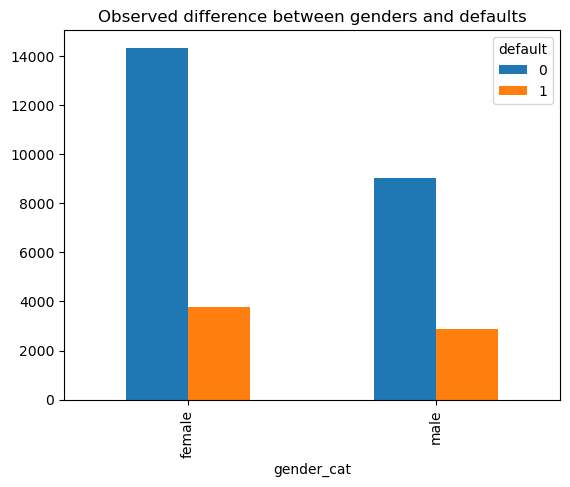

In [61]:
# for easier understanding
gender_dict = {
    1 : 'male',
    2: 'female'
}

credits['gender_cat'] = credits.gender.apply(lambda x: gender_dict[x])

# plotting the bar chart to see how genders may differ
credits.groupby(['gender_cat', 'default']).size().unstack().plot(kind='bar').set_title('Observed difference between genders and defaults');

In [62]:
# point estimate
defa_ratio = defa.shape[0] / credits.shape[0]
nodefa_ratio = nodefa.shape[0] / credits.shape[0]
print(f"Defaulted ratio (point estimate): {defa_ratio}\nNot defaulted ratio (point estimate): {nodefa_ratio}\n")

# wilsons interval
defa_ratio_confint = proportion_confint(defa.shape[0], credits.shape[0], method='wilson')
nodefa_ratio_confint = proportion_confint(nodefa.shape[0], credits.shape[0], method='wilson')

# confidence interval
print(f"Defaulted ratio confint: {defa_ratio_confint}\nNot defaulted ratio confint: {nodefa_ratio_confint}")

Defaulted ratio (point estimate): 0.2212
Not defaulted ratio (point estimate): 0.7788

Defaulted ratio confint: (0.21653915850941435, 0.22593223226370912)
Not defaulted ratio confint: (0.7740677677362909, 0.7834608414905856)


Now, let's run the Mann Whitney U test to check whether the distributions are the same.

In [63]:
# creating a contingency table between gender and default
ct = pd.crosstab(credits.gender, credits.default)

In our contingency table we have no cells with expected frequencies less than 5. Therefore, we can use the chi-square test for independence.

In [64]:
# running chi-squared test
chi2_res = chi2_contingency(ct)

# checking if there are any cells with less than 5 observations
for i in chi2_res.expected_freq:
    print(i)

[9258.3744 2629.6256]
[14105.6256  4006.3744]


Given that we don't have any cells with less than 5 observations, we can use chi-squared test for independence.

In [65]:
print(f"Chi-squared test: statistic = {chi2_res[0]}, p-value = {chi2_res[1]}")

Chi-squared test: statistic = 47.70879689062111, p-value = 4.944678999412044e-12


$p=4.94\times10^{-12}<0.05 \therefore$ we reject $H_0$. None of the expected counts are below 5, so chi-squared test can be considered accurate.

Alternative, we can use a categorical permutation test. 

$H_0$: two groups are drawn from the same distribution  
$H_1$: two groups are drawn from different distributions  

In [66]:
res_perm_cat = permutation_test_cat_ind(credits.gender.values, credits.default.values, 
                               max_permutations = 10000, return_distr = True)

print("Permutation test: t = %f, p = %f" % (res_perm_cat['t'], res_perm_cat['p']))

Permutation test: t = 47.708797, p = 0.000100


p-value for the categorical permutation test > 0.05, so we also reject $H_0$.

Let us check the null distirbution of the test statistic:

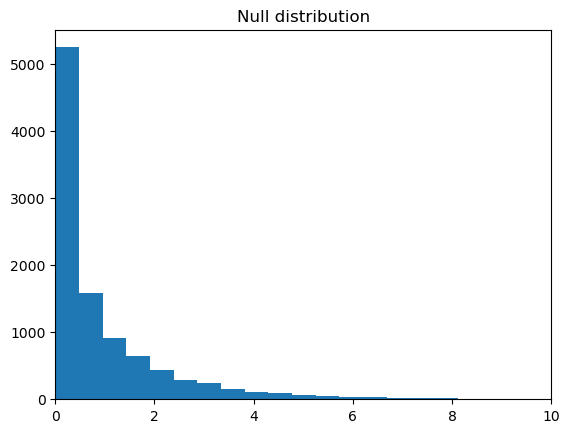

In [67]:
plt.hist(res_perm_cat['null_distr'], bins = 100)
plt.xlim(0, 10)
plt.title('Null distribution')
plt.show()

We can also calculate Pearson's residuals to see which cells contribute the most to the chi-squared statistic.

In [68]:
# calculate pearsons residuals
residuals_gen = contingency_tables.Table(ct).resid_pearson
residuals_gen

default,0,1
gender,,
1,-2.529342,4.746002
2,2.049173,-3.845025


We can see that the residuals greatly deviate from expected for both male and female genders in the 'defaulted' group.

Practically speaking, I can't really say what implications are possible from this analysis - results may surely differ gender-wise, but I don't know how to interpret this.

# Education

Education in our dataset is a categorical variable. Let us examine the data visually first.

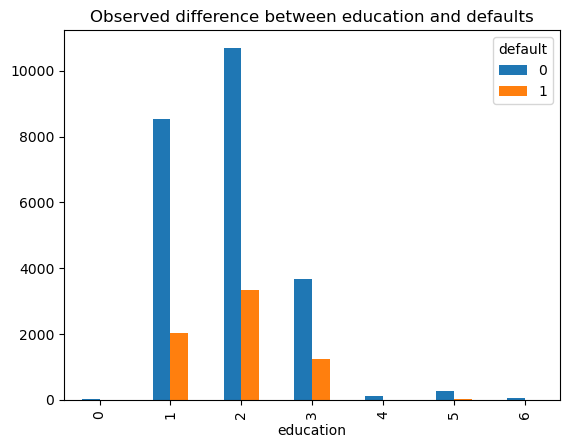

In [69]:
# vis education and default
credits.groupby(['education', 'default']).size().unstack().plot(kind='bar').set_title('Observed difference between education and defaults');

Given the variable is categorical, Mann-Whitney U test can be used to test whether the distributions of the two groups are the same.

$H_0$: the distributions of the two groups are the same  
$H_1$: the distributions of the two groups are not the same

In [70]:
edu_def = defa.education.values
edu_nodef = nodefa.education.values

print(f"Mann-Whitney test: {mannwhitneyu(edu_def, edu_nodef, alternative='two-sided')}")

Mann-Whitney test: MannwhitneyuResult(statistic=81931254.0, pvalue=1.532351818931204e-14)


The p-value of the Mann Whitney U test is less than the significance level $\alpha$ = 0.05. Therefore, we reject the null hypothesis that the distributions of the two groups are the same.

Despite that education is an ordinal variable, we can treat it as categorical and use a chi-square test to test whether the distribution of the variable is the same in both groups.

In [71]:
# contringency table
ct_edu = pd.crosstab(credits.education, credits.default)
ct_edu

default,0,1
education,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [72]:
# run chi-squared test
chi2_res_edu = chi2_contingency(ct_edu)

# manual check of frequencies
for i in chi2_res_edu.expected_freq:
    print(i)

[10.9032  3.0968]
[8243.598 2341.402]
[10926.564  3103.436]
[3829.3596 1087.6404]
[95.7924 27.2076]
[218.064  61.936]
[39.7188 11.2812]


Although we have one observation where expected value is < 5, overall we still have enough observations to use the chi-squared test for independence.

In [73]:
print(f"\nChi-squared test: statistic = {chi2_res_edu[0]}, p-value = {chi2_res_edu[1]}")


Chi-squared test: statistic = 163.21655786997073, p-value = 1.2332626245415605e-32


$p=1.23\times10^{-32} < 0.05 \therefore$ we reject $H_0$. The percentage of of expected frequencies > 5 is above 80%, so chi-squared test can be considered accurate.

Let us check the Pearson's residuals to see which cells contribute the most to the chi-squared statistic.

In [74]:
# calculate pearsons residuals
residuals_edu = contingency_tables.Table(ct_edu).resid_pearson
residuals_edu

default,0,1
education,,
0,0.805729,-1.511796
1,3.365212,-6.314173
2,-2.165726,4.063568
3,-2.412615,4.526808
4,2.064843,-3.874282
5,2.975556,-5.583058
6,0.520746,-0.977080


It seems that the most significant contribution to the chi-squared statistic comes from the 'defaulted' with almost all education levels except for 'doctorate'. 

So, it seems that the education level is related to the default indicator. Practically speaking, it may be worthy to investigate whether the education level is a good predictor of the default indicator.

# Marital status

Let us check the proprortions in both groups.

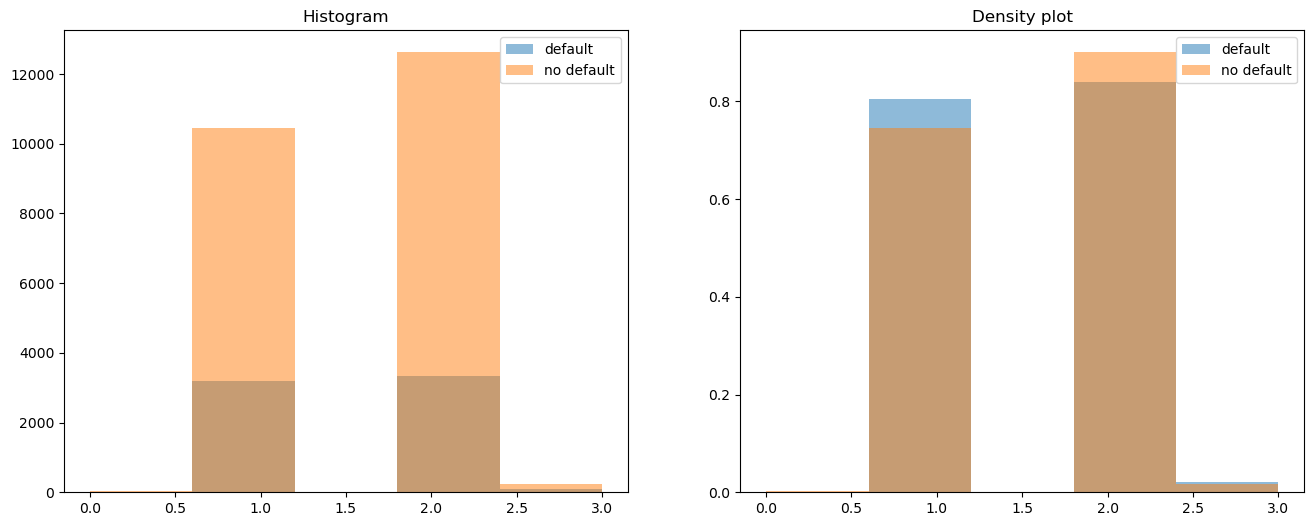

In [76]:
# visualize marital status in two groups

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(defa.marital, bins=5, alpha=0.5, label='default')
ax1.hist(nodefa.marital, bins=5, alpha=0.5, label='no default')
ax1.set_title('Histogram')
ax1.legend()

ax2.hist(defa.marital, bins=5, alpha=0.5, label='default', density=True)
ax2.hist(nodefa.marital, bins=5, alpha=0.5, label='no default', density=True)
ax2.set_title('Density plot')
ax2.legend()

plt.show()

Given that the variable is categorical, we can use a chi-square test to test whether the distribution of the variable is the same in both groups.

$H_0$: two groups are drawn from the same distribution  
$H_1$: two groups are drawn from different distributions  

In [77]:
# run chi-squared test
ct_mar = pd.crosstab(credits.marital, credits.default)

chi2_res_mar = chi2_contingency(ct_mar)

for i in chi2_res_mar.expected_freq:
    print(i)

print(f"\nChi-squared test: statistic = {chi2_res_mar[0]}, p-value = {chi2_res_mar[1]}")

[42.0552 11.9448]
[10637.6292  3021.3708]
[12432.7632  3531.2368]
[251.5524  71.4476]

Chi-squared test: statistic = 35.66239583433609, p-value = 8.825862457577375e-08


$p=8.82\times10^{-8} < 0.05 \therefore$ we reject $H_0$. The percentage of of expected frequencies > 5 is above 80%, so chi-squared test can be considered accurate.

Let us also analize the Pearson residuals.

In [78]:
# calculate pearsons residuals
residuals_gen = contingency_tables.Table(ct_mar).resid_pearson
residuals_gen

default,0,1
marital,,
0,1.070902,-2.009418
1,-1.790103,3.358910
2,1.706124,-3.201335
3,-0.791430,1.485022


As we can see, the most significant contribution to the chi-squared statistic comes from the 'defaulted' group with 'married' and 'single' marital status.

Alternatively, we can use permutation test for independence

In [ ]:
res_perm_mar = permutation_test_cat_ind(credits.marital.values, credits.default.values, 
                               max_permutations = 10000, return_distr = True)

print("Permutation test: t = %f, p = %f" % (res_perm_mar['t'], res_perm_mar['p']))

Permutation test: t = 35.662396, p = 0.000100


$p=0.0001 < 0.05 \therefore$ we reject $H_0$. Let us also check the null distribution of the test statistic.

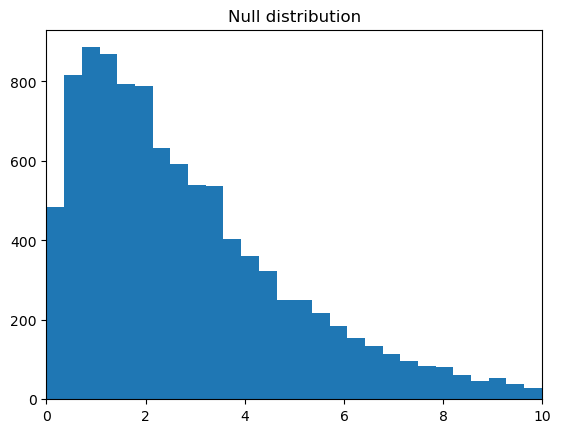

In [79]:
# We also need to check the null distribution of the test statistic
plt.hist(res_perm_mar['null_distr'], bins = 100)
plt.xlim(0, 10)
plt.title('Null distribution')
plt.show()

# Age

Let us first compare sample distributions visually.

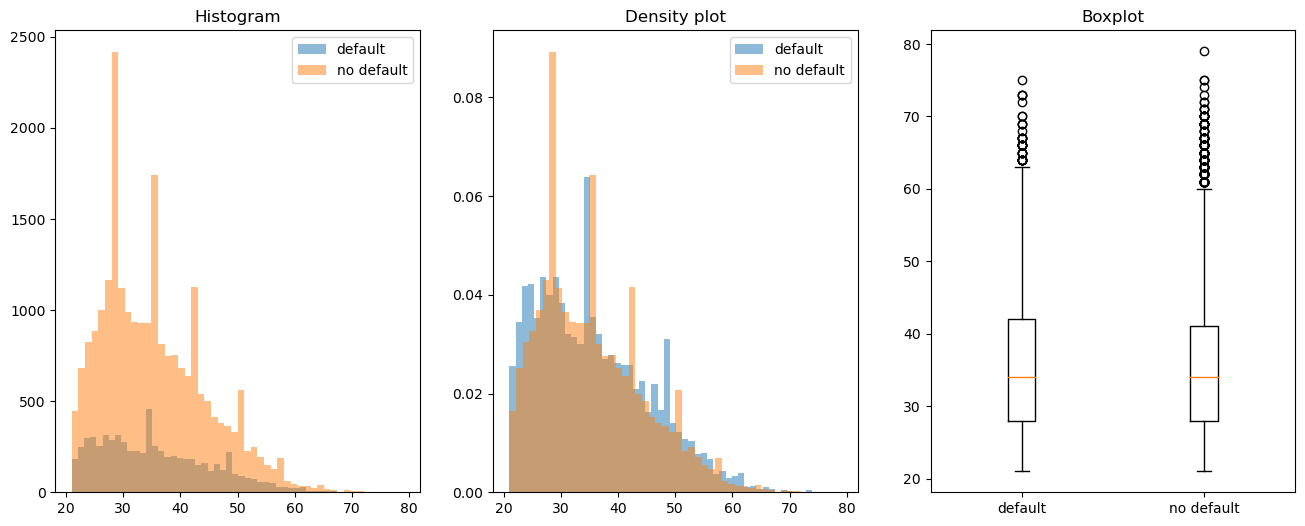

In [80]:
compare_distributions('age')

Although the distributions are not normal, we can still use a t-test to test whether the means of the two groups are the same. The sample is large, so the central limit theorem applies. Hence, right skew should not be a problem given the sample size.

Now, let's check if there is a difference in age between the two groups. First let us find the point estimate for the mean, then find the 95% confidence interval for the mean using bootstrap.

In [ ]:
# point estimate
defa_mean, nodefa_mean = np.mean(defa.age.values), np.mean(nodefa.age.values)
print(f"Defaulted mean (point estimate): {defa_mean}\nNot defaulted mean (point estimate): {nodefa_mean}\n")

# bootstrap
defa_mean_scores = list(map(np.mean, get_bootstrap_samples(defa.age.values, 5000)))
nodefa_mean_scores = list(map(np.mean, get_bootstrap_samples(nodefa.age.values, 5000)))

# confidence interval
defa_mean_confint, nodefa_mean_confint = get_stat_intervals(defa_mean_scores, 0.05), get_stat_intervals(nodefa_mean_scores, 0.05)
print(f"Defaulted mean confint: {defa_mean_confint}\nNot defaulted mean confint: {nodefa_mean_confint}")


Defaulted mean (point estimate): 35.72573839662447
Not defaulted mean (point estimate): 35.417265879130284

Defaulted mean confint: [35.49605937 35.95931661]
Not defaulted mean confint: [35.29860469 35.5382747 ]


Now let us run the t-test.

$H_0$: the means of the two groups are the same
$H_1$: the means of the two groups are not the same

In [ ]:
# run t-test for two independent samples
print(f"t-test: {ttest_ind(defa.age, nodefa.age, alternative='two-sided', equal_var=False)}")

t-test: TtestResult(statistic=2.3195212416592628, pvalue=0.020386490255874648, df=10172.553086166805)


$p < 0.05$, so we reject the null hypothesis that the means are equal. However, we fail to reject the H_0 at 0.01 confidence level.

Alternatively, we can run a non-parametric permutation test for two independent samples (since the distribution is not normal)

In [ ]:
permutation_test_2s(defa.age, nodefa.age, max_permutations = 10000, return_distr = False)

{'t': 0.308472517494188, 'p': 0.0191}

$p < 0.05$, so we reject the null hypothesis that the means are equal. The difference is statistically significant, and confirms the result of the t-test.

Although the difference in means may not huge, it it still statistically significant. Practical significance, however, is questionable - the difference is less than 0.5 years.